In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

SIZE = 8  # map size

env = gym.make('FrozenLake8x8-v1', is_slippery=False)
print(env.desc)

def int2loc(x):
    """
    Convert state number into 2d matrix index
    e.g. 3 -> (0, 4),  4 -> (1, 0)
    """
    return (x // SIZE, x % SIZE)

assert int2loc(8) == (1,0)

[[b'S' b'F' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'F' b'F' b'F']
 [b'F' b'F' b'F' b'F' b'F' b'H' b'F' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'F' b'F' b'F']
 [b'F' b'H' b'H' b'F' b'F' b'F' b'H' b'F']
 [b'F' b'H' b'F' b'F' b'H' b'F' b'H' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'F' b'F' b'G']]


In [2]:
# exploring start for our gridworld

# index for all non-terminal states
valid_start = [s for s in range(64) 
               if env.desc[int2loc(s)] not in 
               (env.desc[int2loc(63)], env.desc[int2loc(59)])]

def random_start(env):
    env.reset()
    env.env.s = np.random.choice(valid_start)
    return env.env.s

# Dyna-Q

In [3]:
from collections import namedtuple
Feedback = namedtuple('feedback', ('reward', 'state_', 'done'))



class Dyna_Q():
    
    def __init__(self, n=10, e=0.2, y=0.9, lr=0.6, shape=(8,8,4), choice=(0,1,2,3)):
        
        self.e = e  # epsilon
        self.n = n  # steps of planning
        self.y = y  # gamma
        self.lr = lr  # learning rate
        self.choice = choice  # action space
        
        self.q = np.random.randn(*shape)               # q-values
        self.model = np.empty(shape, dtype=Feedback)   # array of Feedback tuples, sample model of the environment
        self.visited = np.zeros(shape)                 # boolean array : whether a state-action pair is seen
        
        self.test_mode = False
    
    def action(self, state):
        # epsilon-greedy policy as usual
        if not self.test_mode and np.random.rand() <= self.e:
            action = np.random.choice(self.choice)
        else:
            action = np.argmax(self.q[state])
        return action
    
    def update_q(self, state, action, reward, state_, done):
        # one-step q learning as usual
        q_next = np.max(self.q[state_]) if not done else 0.0
        td_error = reward + self.y*q_next - self.q[(*state, action)]
        self.q[(*state, action)] += self.lr * td_error
    
    def update_model(self, state, action, reward, state_, done):
        # record environment feedback to state-action pair
        self.model[(*state, action)] = Feedback(reward, state_, done)
        self.visited[(*state, action)] = True
    
    def learn(self, *args):
        self.update_model(*args)
        self.update_q(*args)
    
    def plan(self):
        
        i = j = 0
        while i < self.n and j < 200:
            
            # generate random non-terminal state
            state = np.random.randint(0, 62)
            
            # exclude terminal_state & previously unseen states
            if state in valid_start and np.any(self.model[int2loc(state)]):
                
                state = int2loc(state)
                
                # sample random previously taken action
                action = np.random.choice(self.visited[state].nonzero()[0])

                # update q
                self.update_q(state, action, *(self.model[(*state, action)]))
                
                i += 1
            j += 1

In [4]:
def episode(env, agent, test=False, random=False):
    
    agent.test_mode = test
    
    # initialize environment
    state = env.reset() if not random else random_start(env)
    state = int2loc(state)
    
    for step in range(MAX_STEPS):
        
        # act
        action = agent.action(state)
        state_, reward, done, _ = env.step(action)
        state_ = int2loc(state_)
        
        # observe
        agent.learn(state, action, reward, state_, done)

        if done:
            agent.plan()
            return step

        state = state_

In [5]:
EPISODES = 1000
MAX_STEPS = 200
agents = [Dyna_Q() for _ in range(5)]  # n=5 to slightly reduce variance between trials
steps = []

for i in range(EPISODES):
    
    [episode(env, agt, test=False, random=True) for agt in agents];
    
    if i%10 == 0:
        steps.append([episode(env, agt, test=True, random=False) for agt in agents])

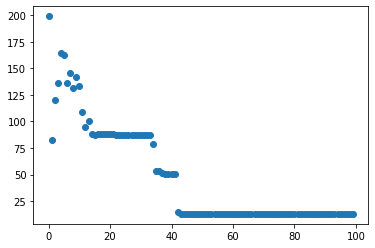

In [6]:
mean_steps = list(map(lambda x: sum(x)/len(x), steps))
plt.scatter(range(len(mean_steps)), mean_steps);

In [7]:
arrows = np.array(['←','↓','→','↑'])
np.array([arrows[np.argmax(agents[0].q, axis=2)[i,j]] 
          if (env.desc[i,j] == env.desc[0,0]) or (env.desc[i,j] == env.desc[0,1]) else env.desc[i,j]
          for i in range(8) for j in range(8)
          ]).reshape(8,8)

array([['↓', '→', '↓', '↓', '→', '↓', '↓', '↓'],
       ['→', '→', '→', '→', '→', '↓', '↓', '↓'],
       ['↓', '↓', '↓', 'H', '→', '→', '↓', '↓'],
       ['→', '→', '→', '→', '↓', 'H', '↓', '↓'],
       ['→', '↑', '↑', 'H', '→', '→', '→', '↓'],
       ['↑', 'H', 'H', '→', '→', '↓', 'H', '↓'],
       ['↓', 'H', '→', '↑', 'H', '↓', 'H', '↓'],
       ['→', '→', '↑', 'H', '→', '→', '→', 'G']], dtype='<U1')

# Dyna-Q +

In [32]:
class Dyna_plus(Dyna_Q):
    def __init__(self, kappa=5e-4, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.visits = np.zeros(self.q.shape)
        self.kappa = kappa
        
    def update_q(self, state, action, reward, state_, done):
        # one-step q learning as usual
        q_next = np.max(self.q[state_]) if not done else 0.0
        
        # td_error with bonus reward
        td_error = reward + self.y*q_next + self.kappa * np.sqrt(self.visits[(*state, action)]) - self.q[(*state, action)]
        self.visits[(*state, action)] = 0
        
        self.q[(*state, action)] += self.lr * td_error
        
    def learn(self, *args):
        self.update_model(*args)
        self.update_q(*args)
        self.visits += 1

In [33]:
EPISODES = 1000
MAX_STEPS = 200
agents = [Dyna_plus(kappa=5e-4) for _ in range(5)]
steps = []

for i in range(EPISODES):
    
    [episode(env, agt, test=False, random=True) for agt in agents];
    
    if i%10 == 0:
        steps.append([episode(env, agt, test=True, random=False) for agt in agents])

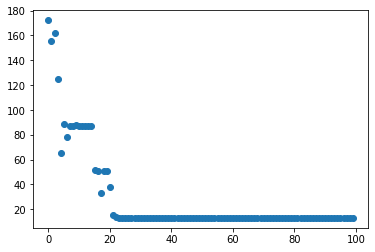

In [34]:
mean_steps = list(map(lambda x: sum(x)/len(x), steps))
plt.scatter(range(len(mean_steps)), mean_steps);

In [35]:
# TODO: Implement proper example for comparison

In [36]:
arrows = np.array(['←','↓','→','↑'])
np.array([arrows[np.argmax(agents[0].q, axis=2)[i,j]] 
          if (env.desc[i,j] == env.desc[0,0]) or (env.desc[i,j] == env.desc[0,1]) else env.desc[i,j]
          for i in range(8) for j in range(8)
          ]).reshape(8,8)

array([['→', '→', '→', '→', '→', '↓', '→', '↓'],
       ['→', '→', '↓', '→', '↓', '→', '↓', '↓'],
       ['→', '↓', '↓', 'H', '↓', '→', '→', '↓'],
       ['→', '→', '→', '→', '↓', 'H', '↓', '↓'],
       ['↑', '↑', '↑', 'H', '→', '↓', '→', '↓'],
       ['↓', 'H', 'H', '→', '→', '↓', 'H', '↓'],
       ['↓', 'H', '→', '↑', 'H', '↓', 'H', '↓'],
       ['→', '→', '↑', 'H', '→', '→', '→', 'G']], dtype='<U1')

# Priortized sweeping

In [77]:
from sortedcontainers import SortedList

class Dyna_PS(Dyna_Q):
    
    def __init__(self, theta=1e-3, *args, **kwargs):
        
        super().__init__(*args, **kwargs)
        self.theta = theta
        self.q = np.zeros((8,8,4))
        
        # initialize backward model as 2d list
        self.back = [[[] for j in range(8)] for i in range(8)]
        
        self.p_queue = SortedList()  # list of (P, (s, a))
        
    def learn(self, *args):
        self.update_model(*args)
        self.update_q(*args)
        self.plan()
    
    def update_q(self, state, action, reward, state_, done):
        
        # calculate priority
        q_next = np.max(self.q[state_]) if not done else 0.0
        p = abs(reward + self.y*q_next - self.q[(*state, action)])
        
        # save into memory instead of update immediately
        if p > self.theta:
            self.p_queue.add((-p, (state, action)))
    
    def update_model(self, state, action, reward, state_, done):
        # record environment dynamics to state-action pair
        # both forward & backward
        self.model[(*state, action)] = Feedback(reward, state_, done)
        if (state, action) not in self.back[state_[0]][state_[1]]:
            self.back[state_[0]][state_[1]].append((state, action)) 
    
    def plan(self):
        
        i = 0
        while len(self.p_queue) > 0 and i < 100:
            
            # select SARS according to priority
            _, (state, action) = self.p_queue[0]
            reward, state_, done = self.model[(*state, action)]
            
            # update q-value(S, A)
            q_next = np.max(self.q[state_]) if not done else 0.0
            td_error = reward + self.y*q_next - self.q[(*state, action)]
            self.q[(*state, action)] += self.lr * td_error

            self.p_queue.pop(0);
            
            # add preceding state-action to the queue
            for prev_state, action in self.back[state[0]][state[1]]:
                reward, _, done = self.model[(*prev_state, action)]
                self.update_q(prev_state, action, reward, state, done)
                
            i += 1
            
        self.p_queue.clear()

In [86]:
EPISODES = 1000
MAX_STEPS = 200
agents = [Dyna_PS(theta=0.01, lr=0.6, e=0.6) for _ in range(5)]
steps = []

for i in range(EPISODES):
    
    [episode(env, agt, test=False, random=True) for agt in agents];
    
    if i%10 == 0:
        steps.append([episode(env, agt, test=True, random=False) for agt in agents])

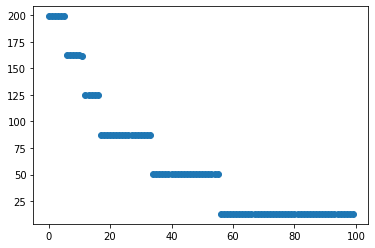

In [87]:
mean_steps = list(map(lambda x: sum(x)/len(x), steps))
plt.scatter(range(len(mean_steps)), mean_steps);

In [89]:
arrows = np.array(['←','↓','→','↑'])
np.array([arrows[np.argmax(agents[0].q, axis=2)[i,j]] 
          if (env.desc[i,j] == env.desc[0,0]) or (env.desc[i,j] == env.desc[0,1]) else env.desc[i,j]
          for i in range(8) for j in range(8)
          ]).reshape(8,8)

array([['→', '↓', '→', '↓', '↓', '↓', '→', '↓'],
       ['→', '→', '→', '→', '↓', '↓', '↓', '↓'],
       ['→', '→', '↓', 'H', '→', '→', '→', '↓'],
       ['→', '→', '→', '→', '↓', 'H', '→', '↓'],
       ['→', '↑', '↑', 'H', '→', '→', '→', '↓'],
       ['↓', 'H', 'H', '→', '→', '↓', 'H', '↓'],
       ['↓', 'H', '→', '↑', 'H', '↓', 'H', '↓'],
       ['→', '→', '↑', 'H', '→', '→', '→', 'G']], dtype='<U1')